# Climate Change and Impacts in Africa

According to the [United Nations](https://www.un.org/en/climatechange/what-is-climate-change), Climate change refers to long-term shifts in temperatures and weather patterns. Such shifts can be natural, due to changes in the sun’s activity or large volcanic eruptions. But since the 1800s, **human activities** have been the main driver of climate change, primarily due to the burning of fossil fuels like coal, oil, and gas.

The consequences of climate change now include, among others, intense droughts, water scarcity, severe fires, rising sea levels, flooding, melting polar ice, catastrophic storms, and declining biodiversity.

## Dataset

*The dataset, IEA-EDGAR CO2, is a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community GHG database version 7.0 (2022) including or based on data from IEA (2021) Greenhouse Gas Emissions from Energy, www.iea.org/statistics, as modified by the Joint Research Centre. The data source was the [EDGARv7.0_GHG website](https://edgar.jrc.ec.europa.eu/dataset_ghg70) provided by Crippa *et. al.* (2022) and with [DOI](https://data.europa.eu/doi/10.2904/JRC_DATASET_EDGAR).*

The dataset contains three sheets - `IPCC 2006`, `1PCC 1996`, and `TOTALS BY COUNTRY` on the amount of CO2 (a greenhouse gas) generated by countries between 1970 and 2021. **You can download the dataset from your workspace or inspect the dataset directly [here](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117)**.

### TOTALS BY COUNTRY SHEET

This sheet contains the annual CO2 (kt) produced between 1970 - 2021 in each country. The relevant columns in this sheet are:

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |


### IPCC 2006

These sheets contain the amount of CO2 by country and the industry responsible. 

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |
| `ipcc_code_2006_for_standard_report_name` | The industry responsible for generating CO2 |

In [27]:
# Setup
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
# The sheet names containing our datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11
# Let's skip the first 10 rows
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# we need only the African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')


# Read the temperatures datasets containing four African countries
# One from each African Region:
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')


## Clean and tidy the datasets

In [28]:
# Rename C_group_IM24_sh, Country_code_A3, ipcc_code_2006_for_standard_report_name columns
ipcc_2006_africa = ipcc_2006_africa.rename(columns={'C_group_IM24_sh':'Region', 'Country_code_A3':'Code',\
                                 'ipcc_code_2006_for_standard_report_name':'Industry'},\
                                          errors='raise')
totals_by_country_africa = totals_by_country_africa.rename(columns={'C_group_IM24_sh':'Region',\
                                                                    'Country_code_A3':'Code'}, errors='raise')

# Drop IPCC_annex, ipcc_code_2006_for_standard_report, and Substance
ipcc_2006_africa.drop(columns=['IPCC_annex', 'ipcc_code_2006_for_standard_report', 'Substance'], inplace=True)
totals_by_country_africa.drop(columns=['IPCC_annex', 'Substance'], inplace=True )

# Melt Y_1970 to Y_2021 into Year and CO2
ipcc_2006_africa = ipcc_2006_africa.melt(id_vars=['Region', 'Code', 'Name', 'Industry', 'fossil_bio'],\
                                         value_vars=ipcc_2006_africa.columns[5:], var_name='Year', value_name='CO2')
totals_by_country_africa = totals_by_country_africa.melt(id_vars=['Region', 'Code', 'Name'],\
                                                         value_vars=totals_by_country_africa.columns[3:],\
                                                         var_name='Year', value_name='CO2')

# Drop missing values
ipcc_2006_africa.dropna(subset='CO2', inplace=True)
totals_by_country_africa.dropna(subset='CO2', inplace=True)

# Convert Year to int
ipcc_2006_africa['Year'] = ipcc_2006_africa.Year.str.replace('Y_', '').astype('int')
totals_by_country_africa['Year'] = totals_by_country_africa.Year.str.replace('Y_', '').astype('int')

print(ipcc_2006_africa.columns, totals_by_country_africa.columns)

Index(['Region', 'Code', 'Name', 'Industry', 'fossil_bio', 'Year', 'CO2'], dtype='object') Index(['Region', 'Code', 'Name', 'Year', 'CO2'], dtype='object')


## Show the trend of `CO2` levels across the African regions

[Text(0.5, 1.0, 'CO2 levels across the African Regions between 1970 and 2021')]

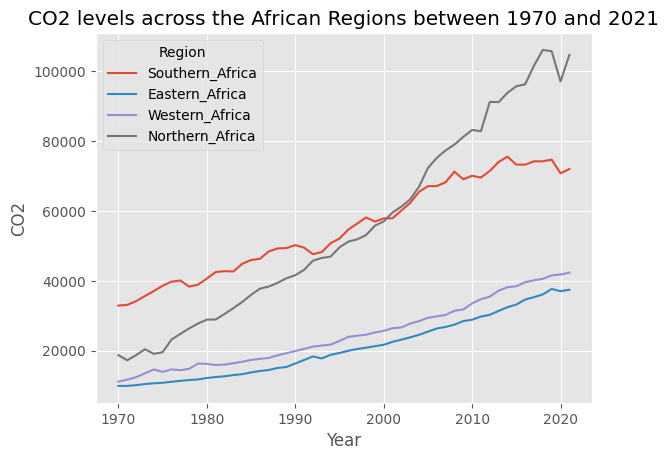

In [29]:
# Create a lineplot of CO2 vs Year
g = sns.lineplot(x='Year', y='CO2', hue='Region', data=totals_by_country_africa, errorbar=None)
g.set(title='CO2 levels across the African Regions between 1970 and 2021')

## Determine the relationship between time (`Year`) and `CO2` levels across the African regions

In [30]:
# Determine the relatiionship between year and CO2 levels across the African regions
relationship_btw_time_CO2 = totals_by_country_africa.groupby('Region')[['CO2', 'Year']].corr(method='spearman')
print(relationship_btw_time_CO2)

                           CO2      Year
Region                                  
Eastern_Africa  CO2   1.000000  0.181768
                Year  0.181768  1.000000
Northern_Africa CO2   1.000000  0.429875
                Year  0.429875  1.000000
Southern_Africa CO2   1.000000  0.260986
                Year  0.260986  1.000000
Western_Africa  CO2   1.000000  0.324071
                Year  0.324071  1.000000


## Determine if there is a significant difference in the CO2 levels among the African Regions

In [31]:
# State significant level
a = 0.05
# Conducting an ANOVA test
aov_results = pingouin.anova(data=totals_by_country_africa, dv='CO2', between='Region')

# Conducting a PAIRWISE-TEST
pw_ttest_result = pingouin.pairwise_tests(data=totals_by_country_africa, dv='CO2', between='Region', padjust='bonf').round(3)
sub_pw_ttest_result = pw_ttest_result[['A', 'B', 'p-corr']].iloc[3]

if sub_pw_ttest_result['p-corr'] <= a:
    print('There is a significant difference in the CO2 levels of the Southern_Africa and Northern_Africa reegion')
else:
    print('There is no significant difference in the CO2 levels of the Southern_Africa and Northern_Africa reegion')


There is no significant difference in the CO2 levels of the Southern_Africa and Northern_Africa reegion


## Determine the most common (top 5) industries in each African region.

In [32]:
# Count the industries by region
Count = ipcc_2006_africa.groupby('Region')['Industry'].value_counts().reset_index(name='Count')

# Top 5 industries in each region
top_5_industries = Count.groupby('Region').head(5)

print(top_5_industries)

             Region                                        Industry  Count
0    Eastern_Africa                   Residential and other sectors   1454
1    Eastern_Africa       Manufacturing Industries and Construction   1383
2    Eastern_Africa   Main Activity Electricity and Heat Production   1174
3    Eastern_Africa             Road Transportation no resuspension    742
4    Eastern_Africa  Non-Energy Products from Fuels and Solvent Use    728
23  Northern_Africa                   Residential and other sectors    572
24  Northern_Africa       Manufacturing Industries and Construction    456
25  Northern_Africa   Main Activity Electricity and Heat Production    315
26  Northern_Africa                                Glass Production    312
27  Northern_Africa             Road Transportation no resuspension    312
46  Southern_Africa                   Residential and other sectors   1144
47  Southern_Africa       Manufacturing Industries and Construction   1067
48  Southern_Africa   Mai

## Determine the industry responsible for the most amount of CO2 (on average) in each African Region

In [33]:
# Average CO2 by Region and Industry
avg_co2 = ipcc_2006_africa.groupby(['Region', 'Industry']).agg({'CO2':'mean'}).reset_index()

max_co2_industries = avg_co2.loc[avg_co2.groupby('Region')['CO2'].idxmax()]
print(max_co2_industries)

             Region                                       Industry  \
18   Eastern_Africa                  Residential and other sectors   
31  Northern_Africa  Main Activity Electricity and Heat Production   
54  Southern_Africa  Main Activity Electricity and Heat Production   
87   Western_Africa                  Residential and other sectors   

             CO2  
18   7904.439282  
31  13612.230148  
54  11377.802504  
87   8702.936136  


## Predict the `CO2` levels (at each African region) in the year 2025

In [34]:
# data provided for you
newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)
# Instantiate LinearRegression
reg = LinearRegression()
y = np.log10(totals_by_country_africa['CO2'])
X = pd.get_dummies(totals_by_country_africa[['Year', 'Region']])
reg.fit(X, y)
predicted_co2 = reg.predict(newdata)
predicted_co2 = np.round(10**predicted_co2, 2)
print(predicted_co2)

[15177.72 10788.07 37761.69 41081.9 ]


## Determine if CO2 levels affect annual temperature in the selected African countries

In [35]:
# Your code here
countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]

selected_countries = totals_by_country_africa[totals_by_country_africa['Name'].isin(countries)][['Name', 'Year', 'CO2']]

temp_long = pd.melt(temperatures, id_vars='Year', value_vars=temperatures.columns[1:], var_name='Name', value_name='Temperature')

joined = pd.merge(selected_countries, temp_long, on=['Name', 'Year'], how='inner')

# Instantiate and fit OLS model
model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3241.
Date:                Mon, 25 Sep 2023   Prob (F-statistic):          1.22e-182
Time:                        22:42:58   Log-Likelihood:                -54.347
No. Observations:                 208   AIC:                             118.7
Df Residuals:                     203   BIC:                             135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.4981      0.583     23.138      0.000      12.348      14.648
Name[T.Mozambique]     2.0759      0.090     23.021      0.000       1.898       2.254
Name[T.Nigeria]        2.8345      0.092     30.884      0.000       2.654       3.016
Name[T.Tunisia]       -1.6254      0.104    -15.673      0.000      -1.830      -1.421
np.log10(CO2)          1.9472      0.117     16.620      0.000       1.716       2.178
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.985
Skew:                          -0.291   Prob(JB):                        0.225
Kurtosis:                       3.073   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""